In [62]:
!pip install torchvision

In [8]:
from google.colab import drive
drive.mount("./gdrive")

Mounted at ./gdrive


In [19]:
!ls "./gdrive/My Drive/data/datasets/test"

0  1  2  3  4  5


In [41]:
%matplotlib inline
import urllib
import pickle
import cv2
import numpy as np
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision import models

import matplotlib.pyplot as plt

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

drive_dir = "gdrive/My Drive/data/datasets/test/"

labels = {
    0:"guu",
    1:"up",
    2:"down",
    3:"right",
    4:"left",
    5:"forward"
}

In [42]:
class SplittedResNet18(nn.Module):
    def __init__(self, resnet18):
        super().__init__()
        self.cnn = nn.Sequential(*list(resnet18.children())[:-1])
        self.flatten = nn.Flatten()
        self.fc = resnet18.fc

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        representation = self.flatten(self.cnn(x))
        output = self.fc(representation)
        return representation, output

model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs,6)
model = model.to(device)

In [90]:
splited_model = SplittedResNet18(model)
splited_model.load_state_dict(torch.load('./gdrive/My Drive/regularizedModel_weights.pth', map_location="cpu"))

pre_model = models.resnet18(pretrained=True)
num_ftrs = pre_model.fc.in_features
pre_model.fc = nn.Linear(num_ftrs,6)
pre_model = pre_model.to(device)
pre_model.load_state_dict(torch.load("./gdrive/My Drive/model_weights.pth",map_location="cpu"))

<ipython-input-90-a24eb7bbefcc>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  splited_model.load_state_dict(torch.load('./gdrive/My Drive/regularizedModel_weights.pth', m

<All keys matched successfully>

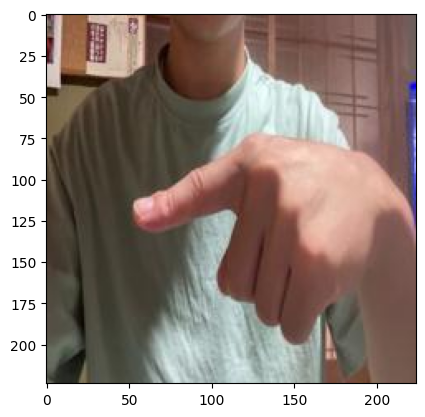

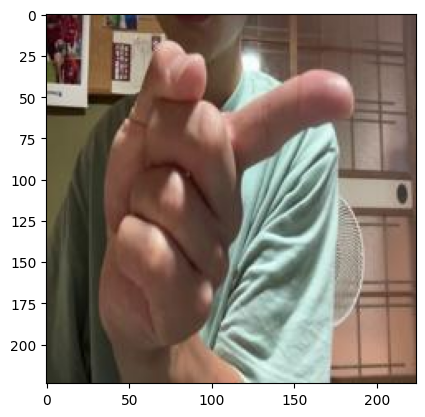

In [27]:
import os
test_image1 = Image.open(os.path.join(drive_dir,"4/LEFT_Light_042.jpg"))
test_image2 = Image.open(os.path.join(drive_dir,"3/RIGHT_Light_060.jpg"))
plt.imshow(test_image1)
plt.show()


In [29]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
test_image1_tensor = transform(test_image1)
test_image2_tensor = transform(test_image2)

test_image1_tensor = test_image1_tensor.unsqueeze(0)
test_image2_tensor = test_image2_tensor.unsqueeze(0)


torch.Size([1, 3, 224, 224])


In [45]:
splited_model.eval()
with torch.no_grad():
  predict1_index = splited_model(test_image1_tensor)[1].max(1)[1]
  predict2_index = splited_model(test_image2_tensor)[1].max(1)[1]
  print("検証画像1の予想結果",labels[int(predict1_index)])
  print("検証画像2の予想結果",labels[int(predict2_index)])

検証画像1の予想結果 left
検証画像2の予想結果 right


In [91]:
print(pre_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [92]:
def gradcam(net,img_fpath):
  net.eval()

  def __extract(grad):
    global feature_grad
    feature_grad = grad
  img = Image.open(img_fpath).convert("RGB")
  transform = transforms.Compose([
      transforms.Resize((224,224)),
      transforms.ToTensor(),
      transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
  ])
  img = transform(img)
  img = img.unsqueeze(0)

  try:
    x = net.cnn[0](img)
    x = net.cnn[1](x)
    x = net.cnn[2](x)
    x = net.cnn[3](x)
    x = net.cnn[4](x)
    x = net.cnn[5](x)
    x = net.cnn[6](x)
    x = net.cnn[7](x)
  except AttributeError:
    x = net.conv1(img)
    x = net.bn1(x)
    x = net.relu(x)
    x = net.maxpool(x)
    x = net.layer1(x)
    x = net.layer2(x)
    x = net.layer3(x)
    x = net.layer4(x)
  features = x

  def __extract_grad(grad):
    global feature_grad
    feature_grad = grad
  features.register_hook(__extract_grad)
  try:
    x = net.cnn[8](x)
    x = x.view(x.size(0),-1)
    output = net.fc(x)
    pred = torch.argmax(output).item()
    print(pred)
  except AttributeError:
    x = net.avgpool(x)
    x = x.view(x.size(0), -1)
    output = net.fc(x)
    pred = torch.argmax(output).item()
    print(pred)

  output[:,pred].backward()

  pooled_grad = torch.mean(feature_grad,dim=[0,2,3])

  features = features.detach()
  for i in range(features.shape[1]):
    features[:,i,:,:] *= pooled_grad[i]

  heatmap = torch.mean(features,dim=1).squeeze()
  heatmap = np.maximum(heatmap,0)

  heatmap = heatmap/torch.max(heatmap)
  heatmap = heatmap.numpy()

  img = cv2.imread(img_fpath)
  heatmap = cv2.resize(heatmap,(img.shape[1],img.shape[0]))
  heatmap = np.uint8(255 * heatmap)
  heatmap = cv2.applyColorMap(heatmap,cv2.COLORMAP_JET)
  superimposed_img = heatmap * 0.4 + img
  superimposed_img = np.uint8(255 * superimposed_img / np.max(superimposed_img))
  superimposed_img = cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB)
  plt.imshow(superimposed_img)
  plt.show()

In [53]:
# feature_vec = feature_grad.view(512,7*7)

# alpha = torch.mean(feature_vec,axis=1)

# feature = feature.squeeze(0)

# L = F.relu(torch.sum(feature*alpha.view(-1,1,1),0))
# L = L.detach().numpy()

# L_min = np.min(L)
# L_max = np.max(L - L_min)
# L = (L - L_min)/L_max

# L = cv2.resize(L,(224,224))

# def toHeatmap(x):
#     x = (x*255).reshape(-1)
#     cm = plt.get_cmap('jet')
#     x = np.array([cm(int(np.round(xi)))[:3] for xi in x])
#     return x.reshape(224,224,3)

# img2 = toHeatmap(L)
# img1 = test_image1_tensor.squeeze(0).permute(1,2,0)
# alpha = 0.5
# grad_cam_image = img1*alpha + img2*(1-alpha)
# plt.imshow(grad_cam_image)

RuntimeError: shape '[512, 49]' is invalid for input of size 512

4


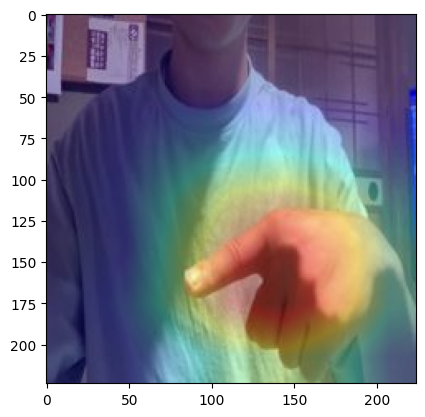

5


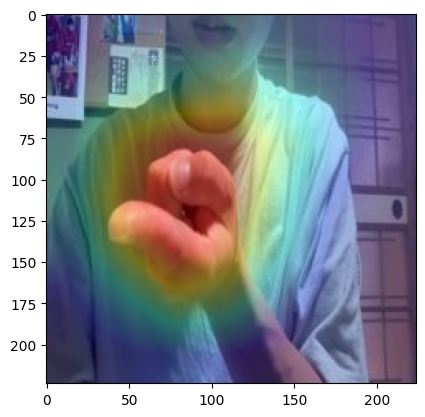

0


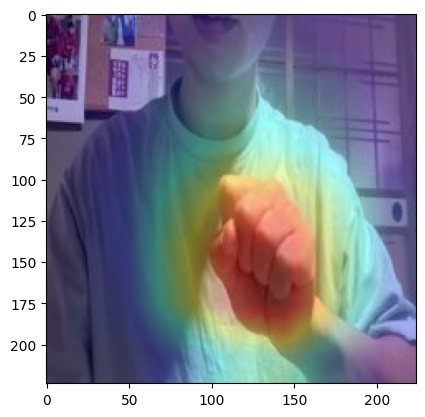

1


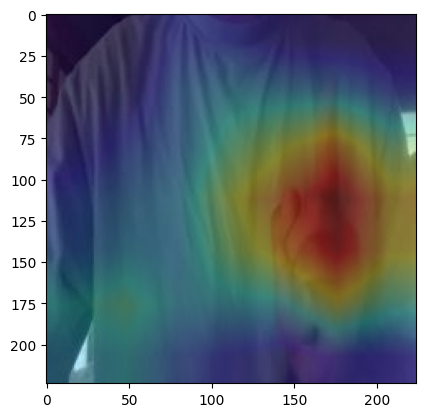

4


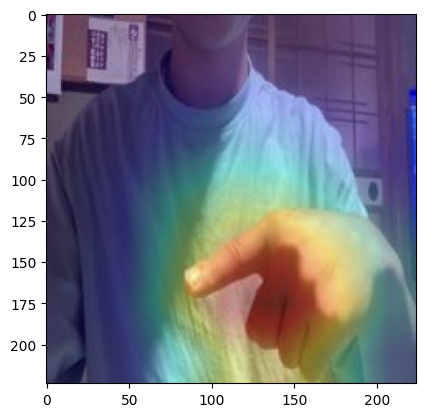

5


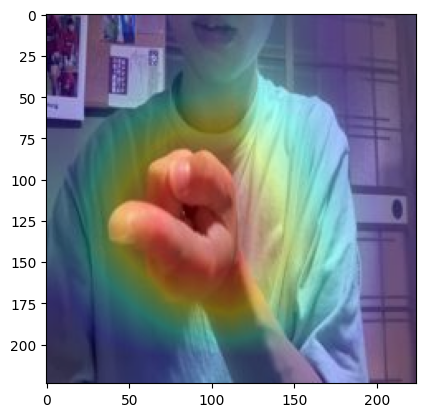

0


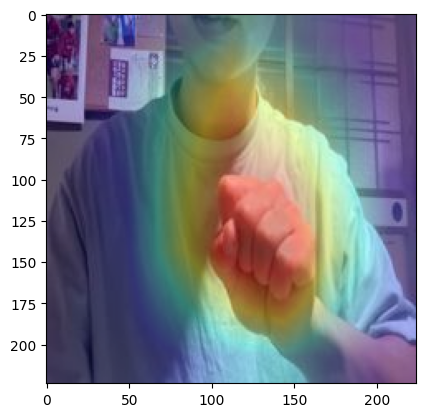

1


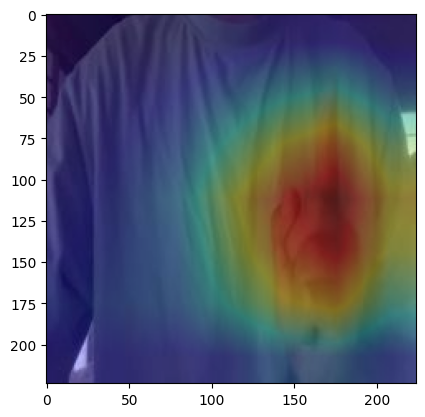

In [93]:
gradcam(splited_model,os.path.join(drive_dir,"4/LEFT_Light_065.jpg"))
gradcam(splited_model,os.path.join(drive_dir,"5/FORWARD_Light_082.jpg"))
gradcam(splited_model,os.path.join(drive_dir,"0/GUU_Light_017.jpg"))
gradcam(splited_model,os.path.join(drive_dir,"1/UP_Dark_022.jpg"))
gradcam(pre_model,os.path.join(drive_dir,"4/LEFT_Light_065.jpg"))
gradcam(pre_model,os.path.join(drive_dir,"5/FORWARD_Light_082.jpg"))
gradcam(pre_model,os.path.join(drive_dir,"0/GUU_Light_017.jpg"))
gradcam(pre_model,os.path.join(drive_dir,"1/UP_Dark_022.jpg"))